# Copied solution
https://www.kaggle.com/meaninglesslives/simple-neural-net-for-time-series-classification

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
gc.enable() # включение garbage collector

train = pd.read_csv('../data/raw/training_set.csv') # считывание тренировочных данных (кривые)
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']

aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

agg_train = train.groupby('object_id').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train.columns = new_columns
agg_train['mjd_diff'] = agg_train['mjd_max'] - agg_train['mjd_min']
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

del agg_train['mjd_max'], agg_train['mjd_min']
agg_train.head()

del train
gc.collect() # сбор мусора


105

In [3]:
agg_train.head()

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,...,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,flux_diff,flux_dif2,flux_w_mean,flux_dif3
object_id,,,,,,,,,,,,,,,,,,,,,
615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,...,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,873.7903,1761.066406,-14.306331,-327.742307,-5.373326
713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,...,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,848.8198,29.506064,-20.730002,-4.884564,-6.040676
730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,...,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,853.8455,66.469870,29.315018,25.373110,2.619697
745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,...,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,853.7060,236.289675,26.521968,152.835617,1.546038
1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,...,0.173295,3.432418e+04,7.868462,3.015599e+06,7.908174,873.7903,160.143942,22.411225,87.856390,1.822792


In [4]:
agg_train.columns

Index(['mjd_size', 'passband_min', 'passband_max', 'passband_mean',
       'passband_median', 'passband_std', 'flux_min', 'flux_max', 'flux_mean',
       'flux_median', 'flux_std', 'flux_skew', 'flux_err_min', 'flux_err_max',
       'flux_err_mean', 'flux_err_median', 'flux_err_std', 'flux_err_skew',
       'detected_mean', 'flux_ratio_sq_sum', 'flux_ratio_sq_skew',
       'flux_by_flux_ratio_sq_sum', 'flux_by_flux_ratio_sq_skew', 'mjd_diff',
       'flux_diff', 'flux_dif2', 'flux_w_mean', 'flux_dif3'],
      dtype='object')

In [5]:
meta_train = pd.read_csv('../data/raw/training_set_metadata.csv') # считывание тренировочных данных (метадата)

full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
# определение веса каждого класса
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)


Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [6]:
meta_train.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [7]:
df_trash = pd.read_csv('../data/raw/test_set_metadata.csv')

In [8]:
df_trash.isna().sum()

object_id                   0
ra                          0
decl                        0
gal_l                       0
gal_b                       0
ddf                         0
hostgal_specz         3372497
hostgal_photoz              0
hostgal_photoz_err          0
distmod                390510
mwebv                       0
dtype: int64

In [9]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz'] # удаление колонок
    del full_train['ra'], full_train['decl'], full_train['gal_l'], full_train['gal_b'], full_train['ddf'] # удаление колонок
    

# заполнение NaN
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) # деление данных на фолды для кросс-валидации

In [10]:
full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

## Построение модели

In [11]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

### Определение функции ошибки

In [13]:
wtable

NameError: name 'wtable' is not defined

In [14]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


In [15]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
#     model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
#     model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
#     model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
#     model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [16]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
    
print(unique_y)
print()
print(class_map)
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
print(y_map)
y_categorical = to_categorical(y_map)


[ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]

{6: 0, 15: 1, 16: 2, 42: 3, 52: 4, 53: 5, 62: 6, 64: 7, 65: 8, 67: 9, 88: 10, 90: 11, 92: 12, 95: 13}
[12 10  3 ...  2  8  0]


In [17]:
y_categorical.shape

(7848, 14)

In [18]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]


In [19]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()


Train on 6274 samples, validate on 1574 samples
Epoch 1/300
 - 1s - loss: 2.2551 - acc: 0.2308 - val_loss: 1.7034 - val_acc: 0.3653
Epoch 2/300
 - 0s - loss: 1.8550 - acc: 0.3226 - val_loss: 1.5424 - val_acc: 0.4771
Epoch 3/300
 - 0s - loss: 1.6702 - acc: 0.3492 - val_loss: 1.4327 - val_acc: 0.4244
Epoch 4/300
 - 0s - loss: 1.6329 - acc: 0.3642 - val_loss: 1.3763 - val_acc: 0.4701
Epoch 5/300
 - 0s - loss: 1.5593 - acc: 0.3760 - val_loss: 1.3242 - val_acc: 0.5210
Epoch 6/300
 - 0s - loss: 1.4862 - acc: 0.3803 - val_loss: 1.2942 - val_acc: 0.5400
Epoch 7/300
 - 0s - loss: 1.4402 - acc: 0.4163 - val_loss: 1.2920 - val_acc: 0.5508
Epoch 8/300
 - 0s - loss: 1.4083 - acc: 0.4162 - val_loss: 1.2944 - val_acc: 0.4828
Epoch 9/300
 - 0s - loss: 1.3793 - acc: 0.4088 - val_loss: 1.2532 - val_acc: 0.5400
Epoch 10/300
 - 0s - loss: 1.3720 - acc: 0.4237 - val_loss: 1.2096 - val_acc: 0.4892
Epoch 11/300
 - 0s - loss: 1.3453 - acc: 0.4158 - val_loss: 1.2075 - val_acc: 0.5146
Epoch 12/300
 - 0s - loss:

Epoch 97/300
 - 0s - loss: 0.9910 - acc: 0.5132 - val_loss: 1.0164 - val_acc: 0.5267
Epoch 98/300
 - 0s - loss: 1.0143 - acc: 0.5062 - val_loss: 1.0289 - val_acc: 0.5400
Epoch 99/300
 - 0s - loss: 1.0005 - acc: 0.5140 - val_loss: 1.0250 - val_acc: 0.5140
Epoch 100/300
 - 0s - loss: 1.0146 - acc: 0.4967 - val_loss: 1.0258 - val_acc: 0.5343
Epoch 101/300
 - 1s - loss: 0.9943 - acc: 0.5123 - val_loss: 1.0308 - val_acc: 0.5006
Epoch 102/300
 - 0s - loss: 1.0017 - acc: 0.5081 - val_loss: 1.0272 - val_acc: 0.5299
Epoch 103/300
 - 0s - loss: 0.9868 - acc: 0.5150 - val_loss: 1.0283 - val_acc: 0.5280
Epoch 104/300
 - 0s - loss: 1.0237 - acc: 0.5088 - val_loss: 1.0498 - val_acc: 0.5216
Epoch 105/300
 - 0s - loss: 0.9915 - acc: 0.5148 - val_loss: 1.0440 - val_acc: 0.5260
Epoch 106/300
 - 0s - loss: 0.9916 - acc: 0.5142 - val_loss: 1.0345 - val_acc: 0.5324
Epoch 107/300
 - 0s - loss: 1.0087 - acc: 0.5126 - val_loss: 1.0129 - val_acc: 0.5222
Epoch 108/300
 - 0s - loss: 1.0013 - acc: 0.5026 - val_lo

Epoch 193/300
 - 0s - loss: 0.9271 - acc: 0.5392 - val_loss: 1.0065 - val_acc: 0.5286
Epoch 194/300
 - 0s - loss: 0.9199 - acc: 0.5281 - val_loss: 1.0230 - val_acc: 0.5559
Epoch 195/300
 - 0s - loss: 0.9338 - acc: 0.5284 - val_loss: 1.0147 - val_acc: 0.5553
Epoch 196/300
 - 0s - loss: 0.9378 - acc: 0.5386 - val_loss: 1.0306 - val_acc: 0.5349
Epoch 197/300
 - 1s - loss: 0.9375 - acc: 0.5247 - val_loss: 0.9982 - val_acc: 0.5241
Epoch 198/300
 - 1s - loss: 0.9196 - acc: 0.5308 - val_loss: 1.0227 - val_acc: 0.5330
Epoch 199/300
 - 0s - loss: 0.9402 - acc: 0.5279 - val_loss: 0.9855 - val_acc: 0.5362
Epoch 200/300
 - 1s - loss: 0.9302 - acc: 0.5347 - val_loss: 1.0190 - val_acc: 0.5419
Epoch 201/300
 - 0s - loss: 0.9133 - acc: 0.5285 - val_loss: 1.0224 - val_acc: 0.5299
Epoch 202/300
 - 0s - loss: 0.9104 - acc: 0.5261 - val_loss: 0.9923 - val_acc: 0.5629
Epoch 203/300
 - 0s - loss: 0.9030 - acc: 0.5424 - val_loss: 0.9965 - val_acc: 0.5661
Epoch 204/300
 - 0s - loss: 0.9164 - acc: 0.5339 - val

Epoch 289/300
 - 0s - loss: 0.9041 - acc: 0.5398 - val_loss: 1.0462 - val_acc: 0.5299
Epoch 290/300
 - 0s - loss: 0.9115 - acc: 0.5295 - val_loss: 1.0177 - val_acc: 0.5451
Epoch 291/300
 - 0s - loss: 0.8905 - acc: 0.5400 - val_loss: 1.0112 - val_acc: 0.5260
Epoch 292/300
 - 0s - loss: 0.8852 - acc: 0.5357 - val_loss: 1.0107 - val_acc: 0.5375
Epoch 293/300
 - 0s - loss: 0.8946 - acc: 0.5336 - val_loss: 1.0393 - val_acc: 0.5305
Epoch 294/300
 - 0s - loss: 0.8934 - acc: 0.5362 - val_loss: 1.0287 - val_acc: 0.5248
Epoch 295/300
 - 0s - loss: 0.8964 - acc: 0.5394 - val_loss: 1.0336 - val_acc: 0.5140
Epoch 296/300
 - 0s - loss: 0.8932 - acc: 0.5338 - val_loss: 1.0315 - val_acc: 0.5337
Epoch 297/300
 - 0s - loss: 0.8938 - acc: 0.5338 - val_loss: 1.0297 - val_acc: 0.5375
Epoch 298/300
 - 0s - loss: 0.8931 - acc: 0.5384 - val_loss: 1.0371 - val_acc: 0.5407
Epoch 299/300
 - 0s - loss: 0.8729 - acc: 0.5276 - val_loss: 1.0640 - val_acc: 0.5565
Epoch 300/300
 - 0s - loss: 0.8681 - acc: 0.5469 - val

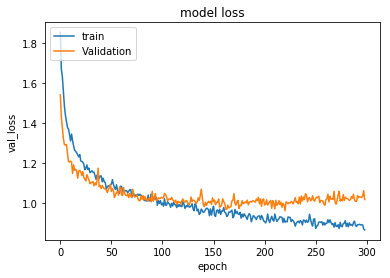

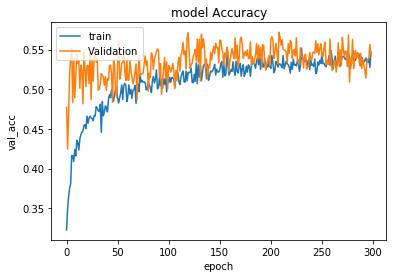

Loading Best Model
(1574, 14)
(1574, 14)
Tensor("Neg:0", shape=(), dtype=float32)
Train on 6276 samples, validate on 1572 samples
Epoch 1/300
 - 1s - loss: 2.2669 - acc: 0.2121 - val_loss: 1.6217 - val_acc: 0.3798
Epoch 2/300
 - 0s - loss: 1.8026 - acc: 0.3190 - val_loss: 1.4465 - val_acc: 0.4803
Epoch 3/300
 - 0s - loss: 1.6922 - acc: 0.3454 - val_loss: 1.3324 - val_acc: 0.5121
Epoch 4/300
 - 0s - loss: 1.5938 - acc: 0.3690 - val_loss: 1.3119 - val_acc: 0.4765
Epoch 5/300
 - 0s - loss: 1.5075 - acc: 0.3864 - val_loss: 1.2665 - val_acc: 0.5299
Epoch 6/300
 - 0s - loss: 1.5255 - acc: 0.3945 - val_loss: 1.2242 - val_acc: 0.5668
Epoch 7/300
 - 0s - loss: 1.4503 - acc: 0.3950 - val_loss: 1.1898 - val_acc: 0.5363
Epoch 8/300
 - 0s - loss: 1.4013 - acc: 0.4141 - val_loss: 1.1698 - val_acc: 0.5604
Epoch 9/300
 - 0s - loss: 1.4174 - acc: 0.3977 - val_loss: 1.1808 - val_acc: 0.5344
Epoch 10/300
 - 0s - loss: 1.3569 - acc: 0.4189 - val_loss: 1.1523 - val_acc: 0.5941
Epoch 11/300
 - 0s - loss: 1.

Epoch 96/300
 - 0s - loss: 1.0240 - acc: 0.5169 - val_loss: 1.0248 - val_acc: 0.5585
Epoch 97/300
 - 0s - loss: 1.0153 - acc: 0.5084 - val_loss: 0.9946 - val_acc: 0.5681
Epoch 98/300
 - 0s - loss: 1.0097 - acc: 0.5169 - val_loss: 0.9774 - val_acc: 0.5712
Epoch 99/300
 - 0s - loss: 1.0081 - acc: 0.5186 - val_loss: 1.0116 - val_acc: 0.5363
Epoch 100/300
 - 0s - loss: 0.9970 - acc: 0.5153 - val_loss: 0.9779 - val_acc: 0.5719
Epoch 101/300
 - 0s - loss: 1.0031 - acc: 0.5116 - val_loss: 0.9846 - val_acc: 0.5693
Epoch 102/300
 - 0s - loss: 1.0314 - acc: 0.5221 - val_loss: 0.9508 - val_acc: 0.5662
Epoch 103/300
 - 0s - loss: 0.9995 - acc: 0.5282 - val_loss: 0.9563 - val_acc: 0.5878
Epoch 104/300
 - 0s - loss: 1.0279 - acc: 0.5147 - val_loss: 1.0707 - val_acc: 0.5458
Epoch 105/300
 - 0s - loss: 1.0122 - acc: 0.5096 - val_loss: 1.0200 - val_acc: 0.5483
Epoch 106/300
 - 0s - loss: 1.0189 - acc: 0.5081 - val_loss: 1.0140 - val_acc: 0.5732
Epoch 107/300
 - 0s - loss: 1.0193 - acc: 0.5083 - val_los

Epoch 192/300
 - 0s - loss: 0.9677 - acc: 0.5354 - val_loss: 0.9828 - val_acc: 0.5553
Epoch 193/300
 - 0s - loss: 0.9616 - acc: 0.5308 - val_loss: 0.9815 - val_acc: 0.5732
Epoch 194/300
 - 0s - loss: 0.9532 - acc: 0.5317 - val_loss: 0.9830 - val_acc: 0.5763
Epoch 195/300
 - 0s - loss: 0.9563 - acc: 0.5287 - val_loss: 1.0025 - val_acc: 0.5884
Epoch 196/300
 - 0s - loss: 0.9542 - acc: 0.5257 - val_loss: 1.0254 - val_acc: 0.5604
Epoch 197/300
 - 0s - loss: 0.9347 - acc: 0.5304 - val_loss: 1.0202 - val_acc: 0.5738
Epoch 198/300
 - 0s - loss: 0.9522 - acc: 0.5373 - val_loss: 1.0409 - val_acc: 0.5662
Epoch 199/300
 - 0s - loss: 0.9479 - acc: 0.5312 - val_loss: 1.0552 - val_acc: 0.5706
Epoch 200/300
 - 0s - loss: 0.9625 - acc: 0.5274 - val_loss: 1.0095 - val_acc: 0.5681
Epoch 201/300
 - 0s - loss: 0.9270 - acc: 0.5405 - val_loss: 1.0038 - val_acc: 0.5515
Epoch 202/300
 - 0s - loss: 0.9500 - acc: 0.5212 - val_loss: 1.0021 - val_acc: 0.5623
Epoch 203/300
 - 0s - loss: 0.9506 - acc: 0.5301 - val

Epoch 288/300
 - 0s - loss: 0.9028 - acc: 0.5542 - val_loss: 1.0392 - val_acc: 0.5770
Epoch 289/300
 - 0s - loss: 0.9084 - acc: 0.5448 - val_loss: 1.0132 - val_acc: 0.5865
Epoch 290/300
 - 0s - loss: 0.8937 - acc: 0.5539 - val_loss: 1.0095 - val_acc: 0.5833
Epoch 291/300
 - 0s - loss: 0.9144 - acc: 0.5392 - val_loss: 1.0121 - val_acc: 0.5827
Epoch 292/300
 - 0s - loss: 0.8986 - acc: 0.5430 - val_loss: 1.0176 - val_acc: 0.5941
Epoch 293/300
 - 0s - loss: 0.9005 - acc: 0.5441 - val_loss: 1.0277 - val_acc: 0.5802
Epoch 294/300
 - 0s - loss: 0.9088 - acc: 0.5478 - val_loss: 1.0217 - val_acc: 0.5802
Epoch 295/300
 - 0s - loss: 0.8967 - acc: 0.5425 - val_loss: 1.0386 - val_acc: 0.5846
Epoch 296/300
 - 0s - loss: 0.9100 - acc: 0.5435 - val_loss: 1.0294 - val_acc: 0.5897
Epoch 297/300
 - 0s - loss: 0.9091 - acc: 0.5387 - val_loss: 0.9920 - val_acc: 0.5795
Epoch 298/300
 - 0s - loss: 0.9084 - acc: 0.5365 - val_loss: 1.0387 - val_acc: 0.5891
Epoch 299/300
 - 0s - loss: 0.8976 - acc: 0.5489 - val

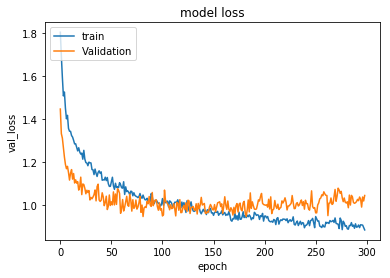

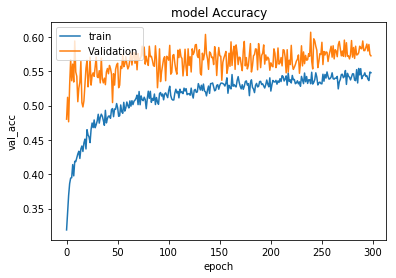

Loading Best Model
(1572, 14)
(1572, 14)
Tensor("Neg_1:0", shape=(), dtype=float32)
Train on 6277 samples, validate on 1571 samples
Epoch 1/300
 - 2s - loss: 2.3125 - acc: 0.2050 - val_loss: 1.7405 - val_acc: 0.2941
Epoch 2/300
 - 0s - loss: 1.8609 - acc: 0.3116 - val_loss: 1.5203 - val_acc: 0.3870
Epoch 3/300
 - 0s - loss: 1.6973 - acc: 0.3470 - val_loss: 1.4252 - val_acc: 0.4468
Epoch 4/300
 - 0s - loss: 1.6223 - acc: 0.3645 - val_loss: 1.3277 - val_acc: 0.4793
Epoch 5/300
 - 0s - loss: 1.5304 - acc: 0.3838 - val_loss: 1.2938 - val_acc: 0.5404
Epoch 6/300
 - 0s - loss: 1.4502 - acc: 0.3933 - val_loss: 1.2558 - val_acc: 0.4621
Epoch 7/300
 - 0s - loss: 1.4389 - acc: 0.4054 - val_loss: 1.2643 - val_acc: 0.4838
Epoch 8/300
 - 0s - loss: 1.4326 - acc: 0.3949 - val_loss: 1.2071 - val_acc: 0.5041
Epoch 9/300
 - 0s - loss: 1.3885 - acc: 0.4182 - val_loss: 1.2046 - val_acc: 0.4749
Epoch 10/300
 - 0s - loss: 1.3807 - acc: 0.4053 - val_loss: 1.2117 - val_acc: 0.4933
Epoch 11/300
 - 0s - loss: 

Epoch 96/300
 - 0s - loss: 1.0187 - acc: 0.5178 - val_loss: 1.1158 - val_acc: 0.5436
Epoch 97/300
 - 0s - loss: 1.0035 - acc: 0.5176 - val_loss: 1.0324 - val_acc: 0.5761
Epoch 98/300
 - 0s - loss: 0.9852 - acc: 0.5144 - val_loss: 1.0336 - val_acc: 0.5538
Epoch 99/300
 - 0s - loss: 0.9949 - acc: 0.5225 - val_loss: 1.0464 - val_acc: 0.5551
Epoch 100/300
 - 0s - loss: 1.0200 - acc: 0.5065 - val_loss: 1.0502 - val_acc: 0.5449
Epoch 101/300
 - 0s - loss: 1.0140 - acc: 0.5106 - val_loss: 1.0294 - val_acc: 0.5557
Epoch 102/300
 - 0s - loss: 0.9970 - acc: 0.5179 - val_loss: 1.0356 - val_acc: 0.5169
Epoch 103/300
 - 0s - loss: 0.9747 - acc: 0.4966 - val_loss: 1.0768 - val_acc: 0.5258
Epoch 104/300
 - 0s - loss: 1.0163 - acc: 0.5135 - val_loss: 1.0457 - val_acc: 0.5353
Epoch 105/300
 - 0s - loss: 0.9861 - acc: 0.5139 - val_loss: 1.0305 - val_acc: 0.5360
Epoch 106/300
 - 0s - loss: 0.9979 - acc: 0.5152 - val_loss: 1.0376 - val_acc: 0.5404
Epoch 107/300
 - 0s - loss: 1.0108 - acc: 0.5141 - val_los

Epoch 192/300
 - 0s - loss: 0.9479 - acc: 0.5241 - val_loss: 1.0601 - val_acc: 0.5512
Epoch 193/300
 - 0s - loss: 0.9274 - acc: 0.5401 - val_loss: 1.1003 - val_acc: 0.5532
Epoch 194/300
 - 0s - loss: 0.9382 - acc: 0.5260 - val_loss: 1.0499 - val_acc: 0.5449
Epoch 195/300
 - 0s - loss: 0.9426 - acc: 0.5337 - val_loss: 1.0751 - val_acc: 0.5582
Epoch 196/300
 - 0s - loss: 0.9292 - acc: 0.5401 - val_loss: 1.0430 - val_acc: 0.5417
Epoch 197/300
 - 0s - loss: 0.9170 - acc: 0.5380 - val_loss: 1.0541 - val_acc: 0.5557
Epoch 198/300
 - 0s - loss: 0.9055 - acc: 0.5523 - val_loss: 1.0563 - val_acc: 0.5532
Epoch 199/300
 - 0s - loss: 0.9310 - acc: 0.5359 - val_loss: 1.0592 - val_acc: 0.5442
Epoch 200/300
 - 0s - loss: 0.9378 - acc: 0.5289 - val_loss: 1.0448 - val_acc: 0.5468
Epoch 201/300
 - 0s - loss: 0.9320 - acc: 0.5327 - val_loss: 1.0353 - val_acc: 0.5493
Epoch 202/300
 - 0s - loss: 0.9189 - acc: 0.5410 - val_loss: 1.0347 - val_acc: 0.5551
Epoch 203/300
 - 0s - loss: 0.9217 - acc: 0.5429 - val

Epoch 288/300
 - 0s - loss: 0.9018 - acc: 0.5308 - val_loss: 1.0484 - val_acc: 0.5595
Epoch 289/300
 - 0s - loss: 0.8932 - acc: 0.5362 - val_loss: 1.0359 - val_acc: 0.5423
Epoch 290/300
 - 0s - loss: 0.8734 - acc: 0.5420 - val_loss: 1.0752 - val_acc: 0.5487
Epoch 291/300
 - 0s - loss: 0.8854 - acc: 0.5460 - val_loss: 1.0552 - val_acc: 0.5398
Epoch 292/300
 - 0s - loss: 0.8796 - acc: 0.5437 - val_loss: 1.0742 - val_acc: 0.5417
Epoch 293/300
 - 0s - loss: 0.8895 - acc: 0.5366 - val_loss: 1.0676 - val_acc: 0.5474
Epoch 294/300
 - 0s - loss: 0.8746 - acc: 0.5469 - val_loss: 1.0708 - val_acc: 0.5493
Epoch 295/300
 - 0s - loss: 0.8700 - acc: 0.5491 - val_loss: 1.0762 - val_acc: 0.5557
Epoch 296/300
 - 0s - loss: 0.8784 - acc: 0.5542 - val_loss: 1.0606 - val_acc: 0.5442
Epoch 297/300
 - 0s - loss: 0.8886 - acc: 0.5402 - val_loss: 1.0664 - val_acc: 0.5430
Epoch 298/300
 - 0s - loss: 0.8880 - acc: 0.5453 - val_loss: 1.0763 - val_acc: 0.5512
Epoch 299/300
 - 0s - loss: 0.8831 - acc: 0.5485 - val

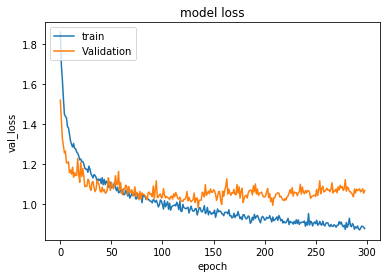

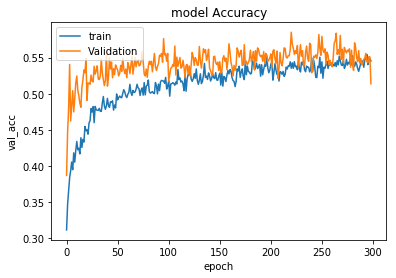

Loading Best Model
(1571, 14)
(1571, 14)
Tensor("Neg_2:0", shape=(), dtype=float32)
Train on 6281 samples, validate on 1567 samples
Epoch 1/300
 - 2s - loss: 2.2444 - acc: 0.2127 - val_loss: 1.6447 - val_acc: 0.2585
Epoch 2/300
 - 0s - loss: 1.8352 - acc: 0.2915 - val_loss: 1.4216 - val_acc: 0.3976
Epoch 3/300
 - 0s - loss: 1.6886 - acc: 0.3569 - val_loss: 1.3634 - val_acc: 0.4295
Epoch 4/300
 - 0s - loss: 1.5928 - acc: 0.3496 - val_loss: 1.3208 - val_acc: 0.4582
Epoch 5/300
 - 0s - loss: 1.5180 - acc: 0.3818 - val_loss: 1.2585 - val_acc: 0.4467
Epoch 6/300
 - 0s - loss: 1.4758 - acc: 0.3963 - val_loss: 1.2762 - val_acc: 0.4703
Epoch 7/300
 - 0s - loss: 1.4188 - acc: 0.4050 - val_loss: 1.2159 - val_acc: 0.4601
Epoch 8/300
 - 0s - loss: 1.4147 - acc: 0.4111 - val_loss: 1.1950 - val_acc: 0.4939
Epoch 9/300
 - 0s - loss: 1.3839 - acc: 0.3990 - val_loss: 1.2526 - val_acc: 0.4391
Epoch 10/300
 - 0s - loss: 1.3771 - acc: 0.4061 - val_loss: 1.1660 - val_acc: 0.4773
Epoch 11/300
 - 0s - loss: 

Epoch 96/300
 - 0s - loss: 1.0199 - acc: 0.5092 - val_loss: 1.0741 - val_acc: 0.5437
Epoch 97/300
 - 0s - loss: 1.0117 - acc: 0.5380 - val_loss: 1.0919 - val_acc: 0.5207
Epoch 98/300
 - 0s - loss: 1.0062 - acc: 0.5074 - val_loss: 1.0751 - val_acc: 0.5329
Epoch 99/300
 - 0s - loss: 1.0135 - acc: 0.5193 - val_loss: 1.0449 - val_acc: 0.5310
Epoch 100/300
 - 0s - loss: 0.9942 - acc: 0.5238 - val_loss: 1.0542 - val_acc: 0.5399
Epoch 101/300
 - 0s - loss: 1.0090 - acc: 0.5213 - val_loss: 1.0443 - val_acc: 0.5475
Epoch 102/300
 - 0s - loss: 1.0112 - acc: 0.5181 - val_loss: 1.0995 - val_acc: 0.5131
Epoch 103/300
 - 0s - loss: 1.0029 - acc: 0.5203 - val_loss: 1.0078 - val_acc: 0.5552
Epoch 104/300
 - 0s - loss: 1.0115 - acc: 0.5101 - val_loss: 1.0597 - val_acc: 0.5520
Epoch 105/300
 - 0s - loss: 0.9867 - acc: 0.5235 - val_loss: 1.0286 - val_acc: 0.5558
Epoch 106/300
 - 0s - loss: 0.9886 - acc: 0.5147 - val_loss: 1.0151 - val_acc: 0.5431
Epoch 107/300
 - 0s - loss: 1.0110 - acc: 0.5119 - val_los

Epoch 192/300
 - 0s - loss: 0.9309 - acc: 0.5426 - val_loss: 1.0009 - val_acc: 0.5565
Epoch 193/300
 - 0s - loss: 0.9361 - acc: 0.5383 - val_loss: 1.0045 - val_acc: 0.5469
Epoch 194/300
 - 0s - loss: 0.9415 - acc: 0.5321 - val_loss: 1.0176 - val_acc: 0.5373
Epoch 195/300
 - 0s - loss: 0.9137 - acc: 0.5447 - val_loss: 1.0329 - val_acc: 0.5520
Epoch 196/300
 - 0s - loss: 0.9142 - acc: 0.5381 - val_loss: 1.0517 - val_acc: 0.5214
Epoch 197/300
 - 0s - loss: 0.9223 - acc: 0.5316 - val_loss: 1.0903 - val_acc: 0.5080
Epoch 198/300
 - 0s - loss: 0.9217 - acc: 0.5318 - val_loss: 1.0518 - val_acc: 0.5469
Epoch 199/300
 - 0s - loss: 0.9220 - acc: 0.5340 - val_loss: 1.0308 - val_acc: 0.5380
Epoch 200/300
 - 0s - loss: 0.9214 - acc: 0.5332 - val_loss: 1.0071 - val_acc: 0.5144
Epoch 201/300
 - 0s - loss: 0.9233 - acc: 0.5384 - val_loss: 1.0137 - val_acc: 0.5195
Epoch 202/300
 - 0s - loss: 0.9153 - acc: 0.5389 - val_loss: 1.0183 - val_acc: 0.5361
Epoch 203/300
 - 0s - loss: 0.9175 - acc: 0.5359 - val

Epoch 288/300
 - 0s - loss: 0.8828 - acc: 0.5490 - val_loss: 1.0604 - val_acc: 0.5265
Epoch 289/300
 - 0s - loss: 0.8991 - acc: 0.5431 - val_loss: 1.1020 - val_acc: 0.5201
Epoch 290/300
 - 0s - loss: 0.9086 - acc: 0.5431 - val_loss: 1.0465 - val_acc: 0.5099
Epoch 291/300
 - 0s - loss: 0.8998 - acc: 0.5375 - val_loss: 1.1011 - val_acc: 0.5303
Epoch 292/300
 - 0s - loss: 0.8827 - acc: 0.5526 - val_loss: 1.1091 - val_acc: 0.5201
Epoch 293/300
 - 0s - loss: 0.8922 - acc: 0.5459 - val_loss: 1.0834 - val_acc: 0.5335
Epoch 294/300
 - 0s - loss: 0.8958 - acc: 0.5349 - val_loss: 1.1208 - val_acc: 0.5201
Epoch 295/300
 - 0s - loss: 0.8992 - acc: 0.5437 - val_loss: 1.0654 - val_acc: 0.5380
Epoch 296/300
 - 0s - loss: 0.8762 - acc: 0.5396 - val_loss: 1.1103 - val_acc: 0.5424
Epoch 297/300
 - 0s - loss: 0.8912 - acc: 0.5354 - val_loss: 1.0593 - val_acc: 0.5348
Epoch 298/300
 - 0s - loss: 0.9014 - acc: 0.5523 - val_loss: 1.0715 - val_acc: 0.5246
Epoch 299/300
 - 0s - loss: 0.8897 - acc: 0.5378 - val

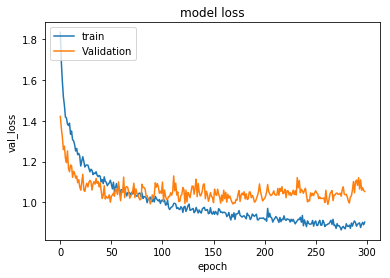

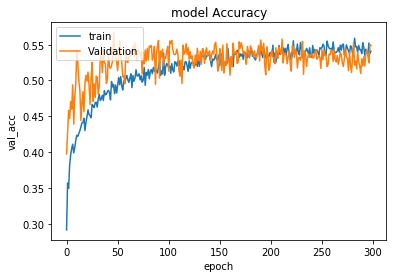

Loading Best Model
(1567, 14)
(1567, 14)
Tensor("Neg_3:0", shape=(), dtype=float32)
Train on 6284 samples, validate on 1564 samples
Epoch 1/300
 - 2s - loss: 2.2856 - acc: 0.2145 - val_loss: 1.6844 - val_acc: 0.2941
Epoch 2/300
 - 0s - loss: 1.8373 - acc: 0.3035 - val_loss: 1.4965 - val_acc: 0.4079
Epoch 3/300
 - 0s - loss: 1.7191 - acc: 0.3340 - val_loss: 1.4240 - val_acc: 0.4405
Epoch 4/300
 - 0s - loss: 1.5884 - acc: 0.3553 - val_loss: 1.3972 - val_acc: 0.4060
Epoch 5/300
 - 0s - loss: 1.5883 - acc: 0.3633 - val_loss: 1.3043 - val_acc: 0.4162
Epoch 6/300
 - 0s - loss: 1.4852 - acc: 0.3722 - val_loss: 1.2735 - val_acc: 0.4405
Epoch 7/300
 - 0s - loss: 1.4315 - acc: 0.3897 - val_loss: 1.2339 - val_acc: 0.4636
Epoch 8/300
 - 0s - loss: 1.3897 - acc: 0.3910 - val_loss: 1.2189 - val_acc: 0.4194
Epoch 9/300
 - 0s - loss: 1.3637 - acc: 0.3959 - val_loss: 1.2283 - val_acc: 0.4802
Epoch 10/300
 - 0s - loss: 1.3718 - acc: 0.3932 - val_loss: 1.2029 - val_acc: 0.4642
Epoch 11/300
 - 0s - loss: 

Epoch 96/300
 - 0s - loss: 1.0305 - acc: 0.4952 - val_loss: 1.0482 - val_acc: 0.5173
Epoch 97/300
 - 0s - loss: 1.0223 - acc: 0.4984 - val_loss: 1.0450 - val_acc: 0.5288
Epoch 98/300
 - 0s - loss: 1.0079 - acc: 0.5102 - val_loss: 1.0240 - val_acc: 0.5198
Epoch 99/300
 - 0s - loss: 1.0072 - acc: 0.5070 - val_loss: 1.0383 - val_acc: 0.5390
Epoch 100/300
 - 0s - loss: 1.0179 - acc: 0.5057 - val_loss: 1.0531 - val_acc: 0.5486
Epoch 101/300
 - 0s - loss: 1.0177 - acc: 0.4959 - val_loss: 1.0217 - val_acc: 0.5422
Epoch 102/300
 - 0s - loss: 1.0094 - acc: 0.5024 - val_loss: 1.0183 - val_acc: 0.5550
Epoch 103/300
 - 0s - loss: 1.0304 - acc: 0.5075 - val_loss: 1.0132 - val_acc: 0.5499
Epoch 104/300
 - 0s - loss: 1.0013 - acc: 0.5032 - val_loss: 1.0135 - val_acc: 0.5352
Epoch 105/300
 - 0s - loss: 1.0439 - acc: 0.4963 - val_loss: 1.0459 - val_acc: 0.5256
Epoch 106/300
 - 0s - loss: 1.0206 - acc: 0.4925 - val_loss: 1.0175 - val_acc: 0.5492
Epoch 107/300
 - 0s - loss: 1.0269 - acc: 0.5013 - val_los

Epoch 192/300
 - 0s - loss: 0.9391 - acc: 0.5313 - val_loss: 0.9914 - val_acc: 0.5364
Epoch 193/300
 - 0s - loss: 0.9182 - acc: 0.5251 - val_loss: 0.9881 - val_acc: 0.5575
Epoch 194/300
 - 0s - loss: 0.9430 - acc: 0.5240 - val_loss: 0.9815 - val_acc: 0.5454
Epoch 195/300
 - 0s - loss: 0.9454 - acc: 0.5161 - val_loss: 0.9981 - val_acc: 0.5831
Epoch 196/300
 - 0s - loss: 0.9682 - acc: 0.5038 - val_loss: 1.0172 - val_acc: 0.5467
Epoch 197/300
 - 0s - loss: 0.9613 - acc: 0.5250 - val_loss: 0.9976 - val_acc: 0.5550
Epoch 198/300
 - 0s - loss: 0.9278 - acc: 0.5205 - val_loss: 0.9939 - val_acc: 0.5627
Epoch 199/300
 - 0s - loss: 0.9277 - acc: 0.5282 - val_loss: 0.9792 - val_acc: 0.5448
Epoch 200/300
 - 0s - loss: 0.9332 - acc: 0.5366 - val_loss: 0.9962 - val_acc: 0.5671
Epoch 201/300
 - 0s - loss: 0.9432 - acc: 0.5236 - val_loss: 0.9906 - val_acc: 0.5748
Epoch 202/300
 - 0s - loss: 0.9316 - acc: 0.5202 - val_loss: 1.0026 - val_acc: 0.5652
Epoch 203/300
 - 0s - loss: 0.9110 - acc: 0.5288 - val

Epoch 288/300
 - 1s - loss: 0.9091 - acc: 0.5251 - val_loss: 0.9884 - val_acc: 0.5409
Epoch 289/300
 - 1s - loss: 0.8850 - acc: 0.5309 - val_loss: 1.0163 - val_acc: 0.5575
Epoch 290/300
 - 1s - loss: 0.9111 - acc: 0.5323 - val_loss: 0.9863 - val_acc: 0.5620
Epoch 291/300
 - 1s - loss: 0.8826 - acc: 0.5325 - val_loss: 0.9786 - val_acc: 0.5435
Epoch 292/300
 - 0s - loss: 0.8994 - acc: 0.5248 - val_loss: 0.9980 - val_acc: 0.5454
Epoch 293/300
 - 1s - loss: 0.9184 - acc: 0.5321 - val_loss: 0.9686 - val_acc: 0.5531
Epoch 294/300
 - 0s - loss: 0.8968 - acc: 0.5361 - val_loss: 0.9696 - val_acc: 0.5505
Epoch 295/300
 - 0s - loss: 0.8935 - acc: 0.5334 - val_loss: 0.9974 - val_acc: 0.5748
Epoch 296/300
 - 0s - loss: 0.8797 - acc: 0.5347 - val_loss: 0.9986 - val_acc: 0.5678
Epoch 297/300
 - 0s - loss: 0.8886 - acc: 0.5277 - val_loss: 0.9688 - val_acc: 0.5620
Epoch 298/300
 - 0s - loss: 0.8986 - acc: 0.5310 - val_loss: 1.0023 - val_acc: 0.5639
Epoch 299/300
 - 0s - loss: 0.8712 - acc: 0.5278 - val

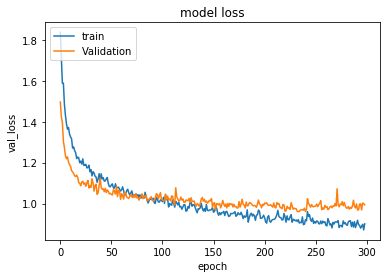

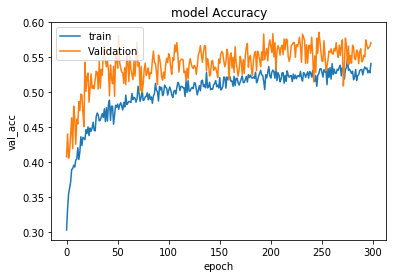

Loading Best Model
(1564, 14)
(1564, 14)
Tensor("Neg_4:0", shape=(), dtype=float32)
MULTI WEIGHTED LOG LOSS : 0.88482 


In [20]:
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 300
batch_size = 100
checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=2,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    print(y_valid.shape)
    print(model.predict_proba(x_valid,batch_size=batch_size).shape)
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(mywloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))


In [26]:
oof_preds.shape

(7848, 14)

In [15]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [16]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [18]:
sample_sub = pd.read_csv('../data/raw/sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()


26202

Normalized confusion matrix
[[8.41e-01 0.00e+00 1.32e-02 0.00e+00 0.00e+00 1.99e-02 0.00e+00 0.00e+00
  9.93e-02 0.00e+00 0.00e+00 0.00e+00 2.65e-02 0.00e+00]
 [2.02e-03 3.96e-01 0.00e+00 5.86e-02 9.49e-02 0.00e+00 7.07e-02 3.84e-02
  0.00e+00 1.82e-01 1.21e-02 1.21e-01 0.00e+00 2.42e-02]
 [5.41e-03 0.00e+00 9.74e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.08e-03
  3.25e-03 0.00e+00 0.00e+00 0.00e+00 1.62e-02 0.00e+00]
 [8.38e-04 1.47e-01 0.00e+00 1.83e-01 1.38e-01 8.38e-04 1.51e-01 4.78e-02
  0.00e+00 1.45e-01 8.38e-03 1.53e-01 0.00e+00 2.60e-02]
 [0.00e+00 1.26e-01 0.00e+00 4.37e-02 3.88e-01 0.00e+00 8.74e-02 1.64e-02
  0.00e+00 1.48e-01 0.00e+00 1.86e-01 0.00e+00 5.46e-03]
 [3.33e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.67e-01 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.65e-01 0.00e+00 6.82e-02 1.01e-01 0.00e+00 2.23e-01 7.23e-02
  0.00e+00 2.75e-01 4.13e-03 7.44e-02 0.00e+00 1.65e-02]
 [9.80e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00

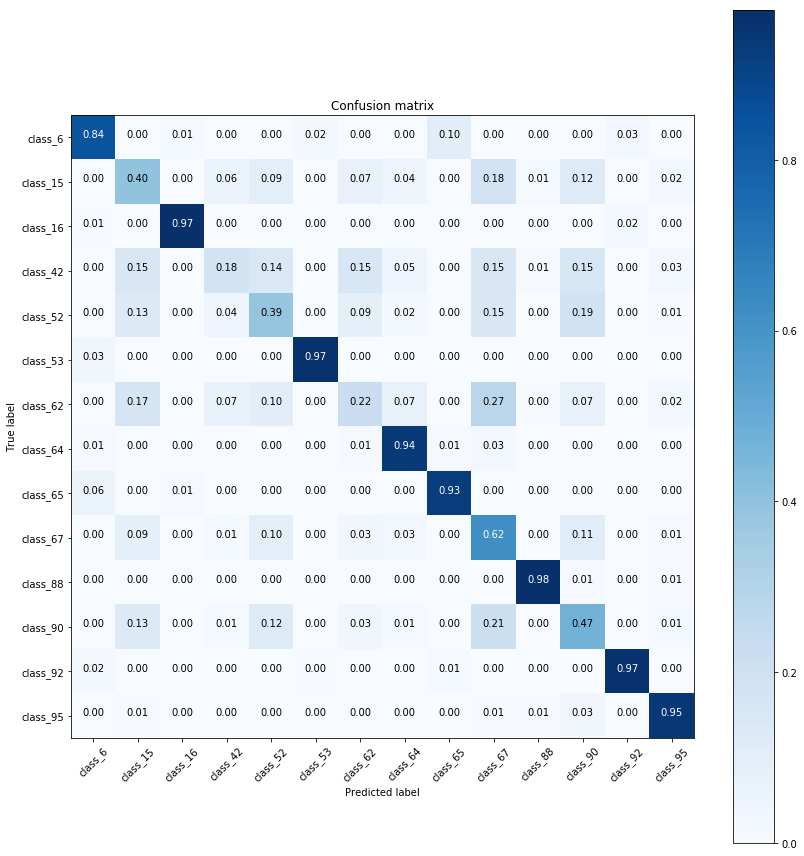

In [19]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [21]:
meta_test = pd.read_csv('../data/raw/test_set_metadata.csv') # считывание тестовых данных (кривые)

import time

start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv('../data/raw/test_set.csv', chunksize=chunks, iterator=True)):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # Group by object id
    agg_test = df.groupby('object_id').agg(aggs)
    agg_test.columns = new_columns
    agg_test['mjd_diff'] = agg_test['mjd_max'] - agg_test['mjd_min']
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']

    del agg_test['mjd_max'], agg_test['mjd_min']
#     del df
#     gc.collect()
    
    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    full_test[full_train.columns] = full_test[full_train.columns].fillna(train_mean)
    full_test_ss = ss.transform(full_test[full_train.columns])
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('../data/submissions/predictions.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('../data/submissions/predictions.csv',  header=False, mode='a', index=False)
        
    del agg_test, full_test, preds_df, preds
#     print('done')
    if (i_c + 1) % 10 == 0:
        print('%15d done in %5.1f' % (chunks * (i_c + 1), (time.time() - start) / 60))

       50000000 done in   5.1
      100000000 done in  10.8
      150000000 done in  16.5
      200000000 done in  22.2
      250000000 done in  27.9
      300000000 done in  33.7
      350000000 done in  39.4
      400000000 done in  45.2
      450000000 done in  51.3


In [22]:
z = pd.read_csv('../data/submissions/predictions.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv('../data/submissions/single_predictions.csv', index=True)

2
88


In [23]:
z.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,2.092491e-05,0.009581,1.891352e-05,0.385556,0.212884,2.074104e-07,0.290095,0.000043,0.000047,0.018884,0.000143,0.082653,4.536868e-07,0.000073,0.155924
14,1.820848e-06,0.006375,3.255423e-06,0.073684,0.227542,4.575380e-07,0.036590,0.000161,0.000108,0.127537,0.004492,0.522556,5.182726e-06,0.000944,0.144584
17,9.550799e-07,0.009783,2.365789e-05,0.099976,0.126518,1.102058e-07,0.036680,0.000122,0.000038,0.053049,0.075860,0.591713,3.557892e-05,0.006200,0.135679
23,5.353507e-07,0.007583,4.471621e-07,0.108888,0.179659,8.533474e-07,0.067515,0.000139,0.000023,0.132494,0.000566,0.499702,7.258828e-07,0.003428,0.149013
34,8.966589e-06,0.010537,3.113280e-08,0.104071,0.130250,2.743362e-07,0.087482,0.000129,0.000060,0.182233,0.000092,0.475869,3.952643e-07,0.009267,0.152222
